In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date
from pathlib import Path
import pickle
import codebase
from codebase import ml_pipeline

- US-Mexico border: 4152050
- below Hoover Dam: 4152103
- Lee's Ferry: 4152450
- upstream of Lake Powell (San Juan River trib): 4152600

In [10]:
basin = grdc_id
files_dir = Path('/global/scratch/users/ann_scheliga/basin_forcing_processed')
dam_name = dam_name.replace(" ", "_")
netcdf_files = list(files_dir.glob("*.pkl"))
netcdf_files.extend(files_dir.glob("*.nc"))
basin_file = [f for f in netcdf_files if f.stem == (str(basin)+'_'+dam_name)]
print(basin_file,flush=True)

[PosixPath('/global/scratch/users/ann_scheliga/basin_forcing_processed/4152450_glen_canyon.pkl')]


In [15]:
netcdf_files[1].stem == (str(basin)+'_'+dam_name)

True

In [1]:
## define experimental set-up

# grdc stored as floats in the downlaod jsons
grdc_id = 1834101
grdc_sub_ids = []#[4152450,4152600] ## MUST BE ORDERED DOWNSTREAM (first) TO UPSTREAM (last)
dam_name = 'kainji'
start_year = 2018
stop_year_ex = 2024
basin_str = 'kainji'

In [2]:
## Other variables and filepaths
grdc_dir = "/global/scratch/users/ann_scheliga/aux_dam_datasets/GRDC_CRB/"
met_dir = "/global/scratch/users/ann_scheliga/era5_data/"
res_dir = "/global/scratch/users/ann_scheliga/CYGNSS_daily/time_series/"
basin_data_dir = "/global/scratch/users/ann_scheliga/basin_forcing_processed/"

In [10]:
test_df = ml_pipeline.LSTM_preprocessing_nh(grdc_id,
    grdc_sub_ids,
    dam_name = 'glen canyon',
    start_year = 2018,
    stop_year_ex = 2024,
    save_output=False,
    basin_str=basin_str,
    res_dir=res_dir
    )

ERROR 1: PROJ: proj_create_from_database: Open of /global/home/users/ann_scheliga/.conda/envs/rioxarray_env/share/proj failed


Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed la

In [17]:
precip_cols = test_df.columns[test_df.columns.str.contains("precip")]
tempK_cols = test_df.columns[test_df.columns.str.contains("tempK")]
dewpoint_cols = test_df.columns[test_df.columns.str.contains("dew")]

<Axes: xlabel='date'>

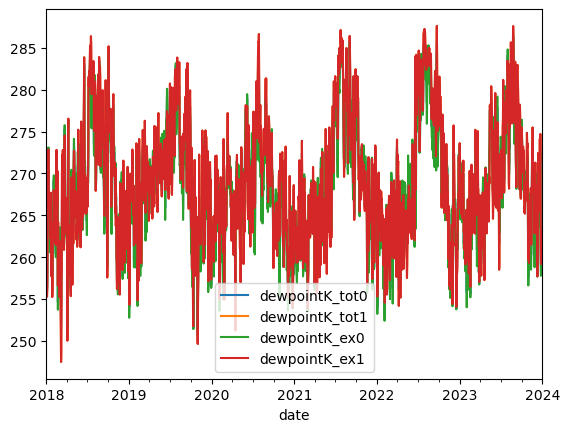

In [18]:
test_df[dewpoint_cols].plot()

<Axes: xlabel='date'>

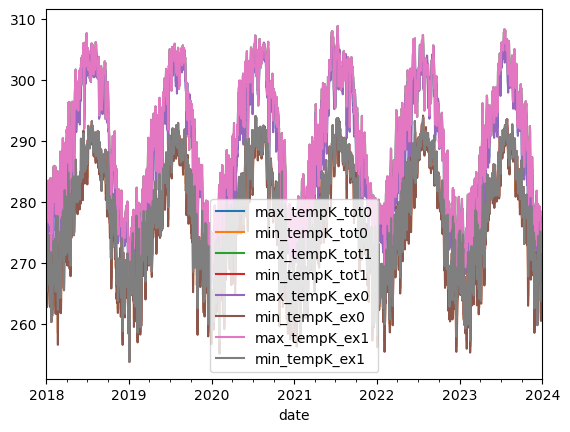

In [15]:
test_df[tempK_cols].plot()

In [7]:
# For debugging
def check_data_format(df):
    print(df.head(2))
    print(df.tail(2))
    print('structure type:',type(df))
    print('index type:',type(df.index))
    print('first index:',df.index[0])
    print('Inferred frequency:',df.index.inferred_freq)


In [8]:
# Create output dataframe
full_time = pd.date_range(start=date(start_year,1,1), end=date(stop_year_ex,1,1),freq='D')
output_df = pd.DataFrame(index = full_time)

In [10]:
## import sw_area
sw_area = codebase.load_data.load_daily_reservoir_CYGNSS_area(
    dam_name, filepath=res_dir
)

output_df['SW_area'] = sw_area
check_data_format(sw_area)

2019-01-01    1692.658133
2019-01-02    1668.817878
Name: Area km2, dtype: float64
2023-12-31    1560.046713
2024-01-01    1527.266361
Name: Area km2, dtype: float64
structure type: <class 'pandas.core.series.Series'>
index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
first index: 2019-01-01 00:00:00
Inferred frequency: D


In [11]:
## Calculate SW_flag
output_df['SW_flag'] = 0
# where SW_area has a value, SW_flag is true
output_df.loc[~output_df['SW_area'].isna(),'SW_flag'] = 1 

check_data_format(output_df['SW_flag'])

2018-01-01    0
2018-01-02    0
Freq: D, Name: SW_flag, dtype: int64
2023-12-31    1
2024-01-01    1
Freq: D, Name: SW_flag, dtype: int64
structure type: <class 'pandas.core.series.Series'>
index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
first index: 2018-01-01 00:00:00
Inferred frequency: D


In [16]:
grdc_Q.shape

(0, 0)

In [15]:
## import GRDC
watershed_gpd, grdc_Q = codebase.load_data.load_GRDC_station_data_by_ID(
    grdc_id,
    filepath=grdc_dir,
    timeseries_dict={"start_year": start_year, "stop_year": stop_year_ex},
    basin_str='niger'
)

output_df['Q'] = grdc_Q
check_data_format(grdc_Q)

ValueError: Cannot set a DataFrame with multiple columns to the single column Q

In [11]:
grdc_sub_ids

[]

In [12]:
# Given that sub-basins exist
subbasins_GRDC = list(map(
    lambda id: codebase.load_data.load_GRDC_station_data_by_ID(
        id,filepath=grdc_dir,
        timeseries_dict={"start_year": start_year, "stop_year": stop_year_ex}
        ),
    grdc_sub_ids))
# subbasin_zipped = dict(zip(grdc_sub_ids,subbasins_GRDC))

# drop flow timeseries tuple from list, leave just the geoDataFrame(s)
subbasin_shps = [output[0] for output in subbasins_GRDC]
def create_XOR_subasins(list_of_shps,base_gpd):
    processed_shps = base_gpd.iloc[:,-1]
    processed_shps.index = ['_ex0']
    processed_shps.index.rename('relative_order',inplace=True)

    for idx, shp in enumerate(list_of_shps):
        shp_to_diff = shp.iloc[0,-1]
        processed_shps = processed_shps.difference(shp_to_diff)
        processed_shps.loc['_ex'+str(idx+1)] = shp_to_diff
    
    # Using the .difference() method wth a shapely shape removes the crs
    processed_shps.set_crs(base_gpd.crs,inplace=True)

    return processed_shps

In [13]:
XOR_geoms = create_XOR_subasins(subbasin_shps,watershed_gpd)

Index(['_ex0'], dtype='object', name='relative_order')


/global/home/users/ann_scheliga/.conda/envs/rio_keras/lib/python3.11/site-packages/geopandas/geoseries.py:628: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


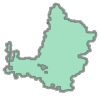

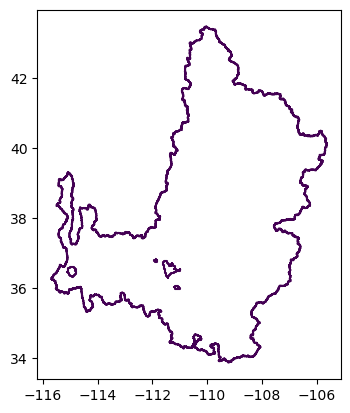

In [14]:
# Sanity check, not essentia
print(XOR_geoms.index)
XOR_geoms.boundary.plot(cmap='viridis')
XOR_geoms[0]

In [15]:
## Can't get mode function to work easily.
# Tried scipy and statistics modules
# type_precip_test = codebase.area_subsets.era5_shape_subset_and_concat_from_file_pattern(
#     filepath = met_dir,
#     input_pattern = r'daily_precip_type',
#     subset_gpd = watershed_gpd,
#     concat_dict = concat_dict,
#     agg_function = mode
# )

/global/home/users/ann_scheliga/.conda/envs/rio_keras/lib/python3.11/site-packages/geopandas/geoseries.py:628: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


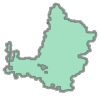

In [16]:
subsets_gpd = pd.concat([watershed_gpd,*subbasin_shps])
subsets_geoms = subsets_gpd['geometry'].reset_index(drop=True).add_prefix('_tot')
subsets_geoms[0]

In [17]:
all_shps = pd.concat([subsets_geoms,XOR_geoms]).rename('geometry')#.reset_index()
all_shps

_tot0    MULTIPOLYGON (((-110.90830 41.35830, -110.9042...
_ex0     MULTIPOLYGON (((-110.90830 41.35830, -110.9042...
Name: geometry, dtype: geometry

In [17]:
output1, output2 = codebase.area_subsets.era5_shape_subset_and_concat_from_file_pattern(
        filepath = met_dir,
        input_pattern = r'daily_max_tempK',
        subset_gpd = watershed_gpd,
        concat_dict = {"dim": "valid_time"},
        agg_function = np.nanmean)

Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area


<Axes: >

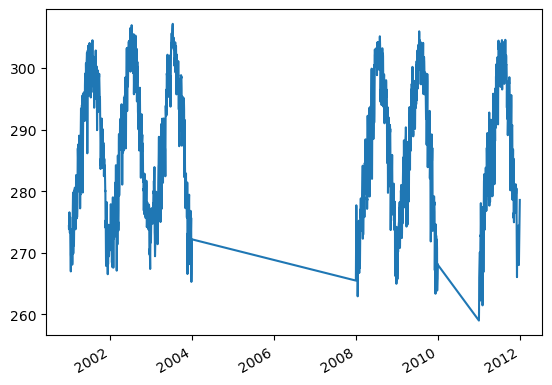

In [18]:
output2.plot()

In [18]:
def add_era5_met_data_by_shp(input_gpd,met_dir,col_suffix = "",start_year=-1,stop_year_ex=-1):
    """
    Load areal aggregated temp and precip based on provided gpd.

    Long Description
    ----------------
    Uses `area_subsets.era5_shape_subset_and_concat_from_file_pattern` for each variable.
    Searches for all instances of a substring (ex: 'daily_tempK'),
    and concatenates all found files according to hard-coded concat_dict dimensions.
    For precipitation, aggregates using np.nansum
    For temperature, aggregates using np.nanmean.
    start and stop year not used, but included in case useful in future edits.

    Inputs
    ------
    input_gpd : geopandas.GeoDataFrame
        geometry to subset data
    col_suffix : str
        default = "" (empty)
        added to column names in final output dataframe
        useful when using this function multiple times
    start_year, stop_year_ex : int
        default = -1
        not used, passed in case future edits need the bounds
        for pattern parsing or filtering.
    """
    
    concat_dict = {"dim": "valid_time"}

    __ , tempK_1dim = codebase.area_subsets.era5_shape_subset_and_concat_from_file_pattern(
        filepath = met_dir,
        input_pattern = r'daily_tempK',
        subset_gpd = input_gpd,
        concat_dict = concat_dict,
        agg_function = np.nanmean
    )
    tempK_1dim.rename('tempK',inplace=True)

    __ , precip_1dim = codebase.area_subsets.era5_shape_subset_and_concat_from_file_pattern(
        filepath = met_dir,
        input_pattern = r'daily_tot_precip',
        subset_gpd = input_gpd,
        concat_dict = concat_dict,
        agg_function = np.nansum
    )
    precip_1dim.rename('precipm',inplace=True)
    met_df = pd.concat([tempK_1dim, precip_1dim],axis=1).add_suffix(col_suffix)
    return met_df

In [20]:
met_list = list(map(lambda idx: add_era5_met_data_by_shp(all_shps.loc[[idx]],met_dir=met_dir,col_suffix=idx),all_shps.index[:2]))

Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Projected to equal area
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider reprojecting!
Grabbed lat/lon dims. Consider 

In [47]:
met_df = pd.concat(met_list,axis=1)
output_df = output_df.join(met_df, how='left')
output_df

,SW_area,SW_flag,Q,tempK_tot0,precipm_tot0,tempK_tot1,precipm_tot1,tempK_tot2,precipm_tot2,tempK_ex0,precipm_ex0,tempK_ex1,precipm_ex1,tempK_ex2,precipm_ex2
2018-01-01,NaN,0,288.831,274.702820,1.053810e-04,272.014923,1.053810e-04,274.270081,0.000000,278.072601,0.000000,270.883575,1.053810e-04,274.270081,0.000000
2018-01-02,NaN,0,286.000,274.541779,4.053116e-05,271.530823,4.053116e-05,273.634369,0.000000,278.328583,0.000000,270.455261,4.053116e-05,273.634369,0.000000
2018-01-03,NaN,0,322.812,272.654816,9.536743e-07,269.692688,9.536743e-07,271.442902,0.000000,276.371490,0.000000,268.809326,9.536743e-07,271.442902,0.000000
2018-01-04,NaN,0,274.956,273.821869,1.721382e-04,270.100128,4.768372e-07,272.195526,0.000000,278.502075,0.000171,269.003815,4.768372e-07,272.195526,0.000000
2018-01-05,NaN,0,247.206,274.513367,0.000000e+00,270.916016,0.000000e+00,272.228882,0.000000,278.977600,0.000000,270.195618,0.000000e+00,272.228882,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,311.090655,1,NaN,271.543335,2.083778e-04,268.223755,2.384186e-06,269.232513,0.000000,275.380585,0.000206,267.675323,2.384186e-06,269.232513,0.000000
2023-12-29,293.913871,1,NaN,272.134460,4.768372e-06,269.295715,4.768372e-06,269.452972,0.000000,275.403564,0.000000,269.164673,4.768372e-06,269.452972,0.000000
2023-12-30,298.685200,1,NaN,273.181702,1.450539e-03,270.166962,1.359463e-03,270.520081,0.000675,276.754852,0.000197,269.923370,5.207062e-04,270.520081,0.000675
2023-12-31,298.685200,1,NaN,273.267059,1.636505e-03,270.942017,1.325607e-03,271.720032,0.000187,276.085724,0.000370,270.514709,1.138687e-03,271.720032,0.000187


In [48]:
output_df.interpolate(
        method="linear", axis=0, inplace=True  , limit=7
    )  # interpolate missing interior values
# output_df.bfill(inplace=True, limit=2)  # backfill missing first precip value
output_df.index.name = 'date'

In [49]:
output_df

,SW_area,SW_flag,Q,tempK_tot0,precipm_tot0,tempK_tot1,precipm_tot1,tempK_tot2,precipm_tot2,tempK_ex0,precipm_ex0,tempK_ex1,precipm_ex1,tempK_ex2,precipm_ex2
date,,,,,,,,,,,,,,,
2018-01-01,NaN,0,288.831,274.702820,1.053810e-04,272.014923,1.053810e-04,274.270081,0.000000,278.072601,0.000000,270.883575,1.053810e-04,274.270081,0.000000
2018-01-02,NaN,0,286.000,274.541779,4.053116e-05,271.530823,4.053116e-05,273.634369,0.000000,278.328583,0.000000,270.455261,4.053116e-05,273.634369,0.000000
2018-01-03,NaN,0,322.812,272.654816,9.536743e-07,269.692688,9.536743e-07,271.442902,0.000000,276.371490,0.000000,268.809326,9.536743e-07,271.442902,0.000000
2018-01-04,NaN,0,274.956,273.821869,1.721382e-04,270.100128,4.768372e-07,272.195526,0.000000,278.502075,0.000171,269.003815,4.768372e-07,272.195526,0.000000
2018-01-05,NaN,0,247.206,274.513367,0.000000e+00,270.916016,0.000000e+00,272.228882,0.000000,278.977600,0.000000,270.195618,0.000000e+00,272.228882,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,311.090655,1,NaN,271.543335,2.083778e-04,268.223755,2.384186e-06,269.232513,0.000000,275.380585,0.000206,267.675323,2.384186e-06,269.232513,0.000000
2023-12-29,293.913871,1,NaN,272.134460,4.768372e-06,269.295715,4.768372e-06,269.452972,0.000000,275.403564,0.000000,269.164673,4.768372e-06,269.452972,0.000000
2023-12-30,298.685200,1,NaN,273.181702,1.450539e-03,270.166962,1.359463e-03,270.520081,0.000675,276.754852,0.000197,269.923370,5.207062e-04,270.520081,0.000675


In [ ]:
output_dict= {grdc_id:output_df}
filename = str(grdc_id)+'.pkl'
pickle.dump(output_dict, open(basin_data_dir+filename, 'wb'))

In [227]:
test_read = pickle.load(open(basin_data_dir+filename, 'rb'))

In [244]:
type(list(test_read.keys())[0])

int